In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#2. Get the file   
downloaded = drive.CreateFile({'id':'15m4e1JbUncRhKmPj8YfrBIefJKBVcUCZ'}) 
#file name
downloaded.GetContentFile('ks-projects-201801.csv') 

downloaded = drive.CreateFile({'id':'1ROXl1B5202_Z0xs56gfblIg7CjrKlnIZ'}) 
#file name
downloaded.GetContentFile('test_one_hot_70.csv') 

downloaded = drive.CreateFile({'id':'1cmJYNnfd0IYBk3U9sLsRjVSz3ihvlsRI'}) 
#file name
downloaded.GetContentFile('train_one_hot_70.csv')

In [2]:
import enum
import time
# import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

TOY_DATA_PATH = "../toy.csv"
DATA_PATH = "ks-projects-201801.csv"
PROCESSED_TOY_DATA_PATH = "../toy_processed.csv"

PROCESSED_TRAIN_PATH = "../data/train.csv"
PROCESSED_TEST_PATH = "../data/test.csv"

PROCESSED80_TRAIN_PATH = "../data/train_80.csv"
PROCESSED80_TEST_PATH = "../data/test_80.csv"

PROCESSED95_TRAIN_PATH = "../data/train_95.csv"
PROCESSED95_TEST_PATH = "../data/test_95.csv"

PROCESSED99_TRAIN_PATH = "../data/train_99.csv"
PROCESSED99_TEST_PATH = "../data/test_99.csv"

STANDARDIZED_TRAIN_PATH = "../data/train_standardized.csv"
STANDARDIZED_TEST_PATH = "../data/test_standardized.csv"

SCALED_TRAIN_PATH = "../data/train_scaled.csv"
SCALED_TEST_PATH = "../data/test_scaled.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

ONE_HOT_TRAIN_PATH_80 = "../data/train_one_hot_80.csv"
ONE_HOT_TEST_PATH_80 = "../data/test_one_hot_80.csv"

FEATURES = ['main_category', 'backers', 'country', 'usd_goal_real', 'duration_in_days']
FEATURES_TO_PLOT = ["main_category", "country", "state"]
FEATURES_TO_DROP = ['ID', 'name', 'category', 'currency', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real']
FEATURES_TO_ENCODE = ["main_category", "country"]
FEATURES_TO_STANDARDIZE = ['backers', 'usd_goal_real', 'duration_in_days']

class TransformMode(enum.Enum):
   NONE = 0
    # Whether to standardize columns in FEATURES_TO_STANDARDIZE
   STANDARDIZE_SELECTED_COLUMNS = 1
    # Whether to scale all FEATURES, final range (0,20)
   SCALE_WITH_RANGE = 2
    # Only scale 'backers', 'usd_goal_real', 'duration_in_days', using default range
   SCALE_SELECTED_COLUMNS = 3

MODE = TransformMode.NONE

'''
    Steps:
    1) Drop unnecessary features
    2) Drop rows whose 'state' is not in ("successful", "failed")
    3) Create a new feature 'duration_in_days' based on the difference between deadline and launched date
    4) One-hot encode categorical data ('main_category' and 'country'), convert 'state' column from String to Integer (1 or 0)
    5) (Skipped) Standardize numerical columns ('backers', 'usd_goal_real', 'duration_in_days')
    6) Randomize/shuffle，and split into train/test set with a ratio of 9:1 (or 7:3, 8:2)
'''
def pre_process():
    df = pd.read_csv(DATA_PATH)
    #examine_data(df)
    #plot_with_pie_chart(df)
    #plot_target_categories(df)

    # Drop the features that are not needed
    drop_features(df)
    # print(" --- number of rows before = {}".format(len(df)))
    df = drop_rows(df)
    # print(" --- number of rows after = {}".format(len(df)))
    df = encode_columns(df)

    # Create a new column "duration_in_days" by calculating
    # the number of days difference between "deadline" and "launched"
    convert_duration_fast(df)

    if MODE == TransformMode.STANDARDIZE_SELECTED_COLUMNS:
        standardize(df)
    elif MODE == TransformMode.SCALE_WITH_RANGE:
        scale(df)
    elif MODE == TransformMode.SCALE_SELECTED_COLUMNS:
        scale_selected_features(df)

    # split data into 70% training set, 30% test set
    train_set, test_set = shuffle_and_split(df, 0.3)
    examine_data(df)

    # df.to_csv(PROCESSED_TOY_DATA_PATH, index=False)

    if MODE == TransformMode.STANDARDIZE_SELECTED_COLUMNS:
        train_set.to_csv(STANDARDIZED_TRAIN_PATH, index=False)
        test_set.to_csv(STANDARDIZED_TEST_PATH, index=False)
    elif MODE == TransformMode.SCALE_WITH_RANGE or MODE == TransformMode.SCALE_SELECTED_COLUMNS:
        train_set.to_csv(SCALED_TRAIN_PATH, index=False)
        test_set.to_csv(SCALED_TEST_PATH, index=False)
    else:
        #train_set.to_csv(PROCESSED_TRAIN_PATH, index=False)
        #test_set.to_csv(PROCESSED_TEST_PATH, index=False)
        train_set.to_csv(ONE_HOT_TRAIN_PATH_70, index=False)
        test_set.to_csv(ONE_HOT_TEST_PATH_70, index=False)

# Plot the y column using a Seaborn countplot
def plot_target_categories(df):
    sns.countplot(x="state", data=df, palette='hls')
    plt.xlabel("Funding Status")
    plt.ylabel("Count")
    plt.title("Count of Funding Outcome")
    plt.show()

def plot_with_pie_chart(df):
    '''
    Categorical data has a categories and a ordered property, which list their possible values
    and whether the ordering matters or not. These properties are exposed as s.cat.categories and s.cat.ordered.
    If you don’t manually specify categories and ordering, they are inferred from the passed arguments.
    '''
    for feature in FEATURES_TO_PLOT:
        labels = df[feature].astype('category').cat.categories.tolist()
        counts = df[feature].value_counts()
        sizes = [counts[var_cat] for var_cat in labels]
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)  # autopct is show the % on plot
        ax1.axis('equal')
        #plt.title("Feature Distribution - " + str(feature))
        ax1.set_title("Feature Distribution - " + str(feature), pad=20)
        plt.show()

def examine_data(df):
    print("\n ------ Examining data... ------")
    print(df.shape)
    #print(df.info())
    #print("List of attributes: ", list(df.columns))
    #print("Total number of attributes: ", len(list(df.columns))-1)

    '''
    backers: min=0, max=219382
    usd_goal_real: min=0.01, max=166361390.71
    duration_in_days: min=0, max=91
    
    for feature in FEATURES_TO_STANDARDIZE:
        print("{}: min={}, max={}".format(feature, df[feature].min(), df[feature].max()))
    '''

    '''
    # Print number of null values (3801 in total)
    print("Number of null values={}".format(df.isnull().values.sum()))
    
    # Column-wise distribution of null values
    # The result shows there are 4 null values in 'name' column, 
    # and 3797 in 'usd pledged' column
    # no need to worry since I don't use these 2 columns anyway
    print(df.isnull().sum())
    '''

    '''
    # print a table of main_category : count
    # Total categories = 15
    print(df['main_category'].value_counts())
    # two ways to get the number of unique values in main_category
    print(df['main_category'].value_counts().count())
    print("Number of unique project categories = {}".format(df['main_category'].nunique()))
    '''

    '''
    # Total defined countries: 22.
    # The only undefined countries "N,0" will occur with state = "undefined", and it's dropped already
    print(df['country'].value_counts())
    print(df['country'].value_counts().count())
    '''

    print("backers: mean={}, median={}, std={}".format(df['backers'].mean(), df['backers'].median(), df['backers'].std()))
    print("usd goal: mean={}, median={}, std={}".format(df['usd_goal_real'].mean(), df['usd_goal_real'].median(), df['usd_goal_real'].std()))
    print("duration in days: mean={}, median={}, std={}".format(df['duration_in_days'].mean(), df['duration_in_days'].median(), df['duration_in_days'].std()))
    print("------ Examination Done! ------")

def drop_features(df):
    for feature in FEATURES_TO_DROP:
        df.drop([feature], axis=1, inplace=True)

# drop all rows whose |state| is not in ("successful", "failed")
def drop_rows(df):
    # df['state']:  (0, 'successful') (1, 'failed') (2, 'failed') (3, 'undefined') (4, 'canceled') ...
    successRows = df[df['state'] == 'successful']
    failedRows = df[df['state'] == 'failed']
    tmp_df = pd.concat([successRows, failedRows])

    # Filter out rows whose 'country' has an invalid value
    return tmp_df[~tmp_df['country'].str.contains("N,0")]
    #validCountries = df[~df['country'].str.contains("N,0")]
    #return pd.concat([successRows, failedRows])

def encode_columns(df):
    # There are 15 categories in total
    # 22 countries in total (excluding the one country that's invalid - N,0)
    '''
    encoder = LabelEncoder()
    for feature in FEATURES_TO_ENCODE:
        df[feature] = encoder.fit_transform(df[feature])

    '''
    # one-hot encode 'country' column
    country_one_hot = pd.get_dummies(df.country, prefix='is_country_')
    df.drop(['country'], axis=1, inplace=True)
    df = pd.concat([df, country_one_hot], axis=1)

    # one-hot encode 'main_category' column
    category_one_hot = pd.get_dummies(df.main_category, prefix='is_category_')
    df.drop(['main_category'], axis=1, inplace=True)
    df = pd.concat([df, category_one_hot], axis=1)

    # Convert state: 'successful' to 1, 'failed' to 0
    df['state'] = df['state'].astype(str)
    df['state'] = np.where(df["state"].str.contains("successful"), 1, 0)
    print("Encoding done!!!")
    print(df.head())
    return df

'''
# The original slow version. DO NOT USE!!!
def convert_duration(df):
    days = []
    for index, row in df.iterrows():
        startDate = str(row['launched']).split()[0]
        endDate = str(row['deadline'])
        start = datetime.datetime.strptime(startDate, "%Y-%m-%d").date()
        end = datetime.datetime.strptime(endDate, "%Y-%m-%d").date()
        duration = (end-start).days
        days.append(duration)
        # print("startDate={}, endDate={}, days={}".format(startDate, endDate, duration))
        print("idx={}, deadline={}, launched={}".format(index, row['deadline'], row['launched']))
    # add the new feature
    df['duration_in_days'] = days

    df.drop(['launched'], axis=1, inplace=True)
    df.drop(['deadline'], axis=1, inplace=True)
'''

def convert_duration_fast(df):
    df['launched'] = pd.to_datetime(df['launched'])
    df['deadline'] = pd.to_datetime(df['deadline'])
    df['duration_in_days'] = (df['deadline'] - df['launched']).dt.days

    df.drop(['launched'], axis=1, inplace=True)
    df.drop(['deadline'], axis=1, inplace=True)

def standardize(df):
    # df[FEATURES_TO_TRANSFORM] = df[FEATURES_TO_TRANSFORM].apply(lambda x: StandardScaler().fit_transform(x))
    features = df[FEATURES_TO_STANDARDIZE]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[FEATURES_TO_STANDARDIZE] = features

def scale(df):
    features = df[FEATURES]
    scaler = MinMaxScaler(feature_range=(0, 20)).fit(features.values)
    features = scaler.transform(features.values)

    df[FEATURES] = features

def scale_selected_features(df):
    features = df[['backers', 'usd_goal_real', 'duration_in_days']]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)

    df[['backers', 'usd_goal_real', 'duration_in_days']] = features

# Adapted from page 52 of the book
# Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd Edition)
# Total rows: 331675
def shuffle_and_split(data, test_ratio):
    size = len(data)
    shuffled_indices = np.random.permutation(size)
    test_set_size = int(size * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

if __name__ == '__main__':
    start_time = time.time()
    pre_process()
    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

Encoding done!!!
      deadline             launched  state  backers  usd_goal_real  \
5   2016-04-01  2016-02-26 13:38:27      1      224       50000.00   
6   2014-12-21  2014-12-01 18:30:44      1       16        1000.00   
11  2013-04-08  2013-03-09 06:42:58      1      100       12500.00   
14  2017-05-03  2017-04-05 19:44:18      1      761        6469.73   
18  2012-08-17  2012-08-02 14:11:32      1        7         250.00   

    is_country__AT  is_country__AU  is_country__BE  is_country__CA  \
5                0               0               0               0   
6                0               0               0               0   
11               0               0               0               0   
14               0               0               0               0   
18               0               0               0               0   

    is_country__CH  ...  is_category__Fashion  is_category__Film & Video  \
5                0  ...                     0                    

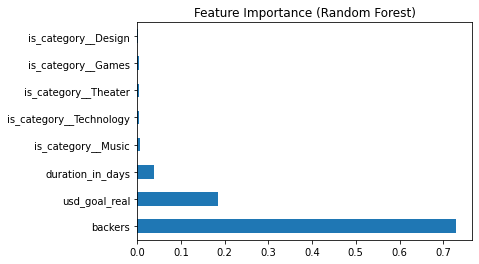

[[55095  4038]
 [ 2877 37429]]
test score: 0.930459879926387
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     59133
           1       0.90      0.93      0.92     40306

    accuracy                           0.93     99439
   macro avg       0.93      0.93      0.93     99439
weighted avg       0.93      0.93      0.93     99439

Time taken: 22.290058135986328


In [3]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

FEATURES = ['backers', 'usd_goal_real', 'is_country__AT','is_country__AU','is_country__BE','is_country__CA','is_country__CH','is_country__DE','is_country__DK','is_country__ES','is_country__FR','is_country__GB','is_country__HK','is_country__IE','is_country__IT','is_country__JP','is_country__LU','is_country__MX','is_country__NL','is_country__NO','is_country__NZ','is_country__SE','is_country__SG','is_country__US','is_category__Art','is_category__Comics','is_category__Crafts','is_category__Dance','is_category__Design','is_category__Fashion','is_category__Film & Video','is_category__Food','is_category__Games','is_category__Journalism','is_category__Music','is_category__Photography','is_category__Publishing','is_category__Technology','is_category__Theater', 'duration_in_days']
#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

class TransformMode(enum.Enum):
   NONE = 0
    # Whether to standardize columns in FEATURES_TO_STANDARDIZE
   STANDARDIZE_SELECTED_COLUMNS = 1
    # Whether to scale all FEATURES, final range (0,20)
   SCALE_WITH_RANGE = 2
    # Only scale 'backers', 'usd_goal_real', 'duration_in_days', using default range
   SCALE_SELECTED_COLUMNS = 3

MODE = TransformMode.NONE

def decision_tree(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    DT = DecisionTreeClassifier(criterion="entropy", max_depth=11)

    #DT = do_search_trees(DT, train_X, train_y)
    DT.fit(train_X, train_y)

    #tree.plot_tree(DT)
    #plt.show()
    pred_y = DT.predict(test_X)
    plot_tree(DT, 8)
    evaluate(DT, test_X, test_y, pred_y)

def random_forest(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #RF = do_search_forest(train_X, train_y)
    RF = RandomForestClassifier(n_estimators=70, max_depth=20, criterion='entropy')
    RF.fit(train_X, train_y)
    pred_y = RF.predict(test_X)
    plot_forest(RF, 8)
    evaluate(RF, test_X, test_y, pred_y)

def do_search_both(train_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]
    do_search_trees(train_X, train_y)
    do_search_forest(train_X, train_y)

def do_search_trees(train_X, train_y):
    param_max_depth = list(range(8, 12))
    param_criterion = ['gini', 'entropy']
    param_grid = [{'max_depth': param_max_depth
                   #'criterion': param_criterion
                   }]
    gs = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'),
                      param_grid=param_grid,
                      cv=5,
                      n_jobs=-1,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search (DT): {}".format(gs.best_score_))
    print("Best parameters from grid search (DT): {}".format(gs.best_params_))
    return gs.best_estimator_

def do_search_forest(train_X, train_y):
    param_max_depth = [10, 15, 20]
    param_criterion = ['gini', 'entropy']
    param_n_estimators = [10, 20, 70]
    param_grid = [{'max_depth': param_max_depth,
                   #'criterion': param_criterion,
                   'n_estimators': param_n_estimators}]
    gs = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                      param_grid=param_grid,
                      n_jobs=-1,
                      scoring='accuracy')
    gs.fit(train_X, train_y)
    print("Best score from grid search (RF): {}".format(gs.best_score_))
    print("Best parameters from grid search (RF): {}".format(gs.best_params_))
    return gs.best_estimator_

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    accuracy = accuracy_score(test_y, pred_y)
    result = precision_recall_fscore_support(test_y, pred_y)
    f1 = result[2][0]
    if do_print:
        print_metrics(model, score, confusion, test_y, pred_y)
    return accuracy, f1

def print_metrics(tree_model, score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))
    #tree.plot_tree(tree_model)
    #plt.show()

def plot_tree(DT, n):
    feat_importances = pd.Series(DT.feature_importances_, index=FEATURES)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.title("Feature Importance (Decision Trees)")
    plt.show()

def plot_forest(RF, n):
    feat_importances = pd.Series(RF.feature_importances_, index=FEATURES)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.title("Feature Importance (Random Forest)")
    plt.show()

# ============================================

if __name__ == '__main__':
    start_time = time.time()

    # train_data = pd.read_csv(TRAIN_DATA_PATH)
    # test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    #decision_tree(train_data, test_data)
    random_forest(train_data, test_data)

    #do_search_both(train_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

In [4]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

DATA_PATH_1 = "../data/test_99.csv"
DATA_PATH_5 = "../data/test_95.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def svm(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #SVM = do_search_linear_svm(train_X, train_y)
    #SVM = LinearSVC(C=0.5)
    SVM = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
    #SVM = SVC()
    #SVM = do_search_svm(train_X, train_y)
    SVM.fit(train_X, train_y)

    pred_y = SVM.predict(test_X)
    evaluate(SVM, test_X, test_y, pred_y)

def svm_using_sgd(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #SGD = SGDClassifier(loss="hinge", penalty="l2", early_stopping=True, max_iter=100, shuffle=False, verbose=0)
    SGD = do_search_linear_svm_sgd(train_X, train_y)
    SGD.fit(train_X, train_y)
    # new_weights = SGD.coef_
    print("Learned weights: {}".format(SGD.coef_))
    print("Converged after {} iterations".format(SGD.n_iter_))

    pred_y = SGD.predict(test_X)
    evaluate(SGD, test_X, test_y, pred_y)


def do_search_svm(train_X, train_y):
    param_C = [0.1, 1.0, 10.0, 50, 100.0]
    param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    param_grid = [{'C': param_C,
                   'gamma': param_gamma,
                   'kernel': ['rbf', 'sigmoid', 'poly']}]
    gs = GridSearchCV(estimator=SVC(),

                      param_grid=param_grid,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))
    return gs.best_estimator_

def do_search_linear_svm_sgd(train_X, train_y):
    #param_loss = ['hinge']
    param_alpha = [0.0001, 0.001, 0.01, 0.1]
    #param_eta0 = [0.1, 0.5]
    param_grid = [{ #'eta0': param_eta0,
                    'alpha': param_alpha
                   #'loss': param_loss,
                  }]
    gs = GridSearchCV(estimator=SGDClassifier(early_stopping=True, loss='hinge'),
                      param_grid=param_grid,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))
    return gs.best_estimator_


def do_search_linear_svm(train_X, train_y):
    '''
    param_C = [0.1, 1.0, 10.0, 50, 100.0]
    param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    param_grid = [{'C': param_C,
                   'gamma': param_gamma,
                   'kernel': ['rbf', 'sigmoid', 'poly']}]
    '''
    #param_loss = ['hinge', 'squared_hinge']
    param_C = [0.5, 1.0, 2.0, 5.0]
    param_grid = [{'C': param_C
                   #'loss': param_loss,
                  }]
    gs = GridSearchCV(estimator=LinearSVC(max_iter=1000),
                      param_grid=param_grid,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))
    return gs.best_estimator_

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))


if __name__ == '__main__':
    start_time = time.time()

    #train_data = pd.read_csv(TRAIN_DATA_PATH)
    #test_data = pd.read_csv(TEST_DATA_PATH)

    #train_data = pd.read_csv(DATA_PATH_5)
    #test_data = pd.read_csv(DATA_PATH_1)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    svm(test_data, train_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

[[137321   1160]
 [ 85313   8232]]
test score: 0.6273133183350141
              precision    recall  f1-score   support

           0       0.62      0.99      0.76    138481
           1       0.88      0.09      0.16     93545

    accuracy                           0.63    232026
   macro avg       0.75      0.54      0.46    232026
weighted avg       0.72      0.63      0.52    232026

Time taken: 8036.612647294998
